# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [14]:
from networks_pyg.GCN import *
# from datasets.Myloader import traffic_mtsc_loader
from datasets.dataloader_extend import traffic_loader_extend
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--kfold", type=int, default=None,
        help="K-fold cross validation")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'



## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [6]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [7]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]

# Dataset Loading

### Anomaly Ratio Check

In [31]:


for target_sid in ['1210005301','1030001902']:   ## 1210005301  ## 1030001902
    
    train_ratio_all, val_ratio_all, test_ratio_all = [], [], []
    
    for k in range(10):
        args.dataset = '{}_CV2'.format(target_sid)
        args.kfold = k
        args.bidirect = False
        print(args.dataset, args.kfold)
        train_loader, val_loader, test_loader = traffic_mtsc_loader(args)

        y_all = []
        for data in train_loader:
            y_all.append(data.y)
        y_all = torch.concat(y_all).unique(return_counts=True)
        train_ratio = y_all[1][1] / y_all[1].sum()
#         print(y_all[1])

        y_all = []
        for data in val_loader:
            y_all.append(data.y)
        y_all = torch.concat(y_all).unique(return_counts=True)
        if len(y_all[1]) == 1:
            val_ratio = 0
        else:
            val_ratio = y_all[1][1] / y_all[1].sum()
#         print(y_all[1])
        
        y_all = []
        for data in test_loader:
            y_all.append(data.y)
        y_all = torch.concat(y_all).unique(return_counts=True)
        if len(y_all[1]) == 1:
            test_ratio = 0
        else:
            test_ratio = y_all[1][1] / y_all[1].sum()
#         print(y_all[1])

        print(train_ratio, val_ratio, test_ratio)

        train_ratio_all.append(train_ratio)
        val_ratio_all.append(val_ratio)
        test_ratio_all.append(test_ratio)
        
    print(np.mean(train_ratio_all),np.mean(val_ratio_all),np.mean(test_ratio_all))

1210005301_CV2 0
tensor(0.0272) tensor(0.0058) tensor(0.0264)
1210005301_CV2 1
tensor(0.0230) tensor(0.0081) tensor(0.0391)
1210005301_CV2 2
tensor(0.0225) tensor(0.0297) tensor(0.0174)
1210005301_CV2 3
tensor(0.0221) tensor(0.0349) tensor(0.0139)
1210005301_CV2 4
tensor(0.0210) tensor(0.0354) tensor(0.0159)
1210005301_CV2 5
tensor(0.0243) tensor(0.0050) tensor(0.0360)
1210005301_CV2 6
tensor(0.0169) tensor(0.0247) tensor(0.0415)
1210005301_CV2 7
tensor(0.0268) tensor(0.0262) tensor(0.0062)
1210005301_CV2 8
tensor(0.0354) tensor(0.0080) 0
1210005301_CV2 9
tensor(0.0114) tensor(0.0571) tensor(0.0185)
0.023057606 0.023488045 0.02149406271055341
1030001902_CV2 0
tensor(0.0362) tensor(0.0490) tensor(0.0272)
1030001902_CV2 1
tensor(0.0382) tensor(0.0257) tensor(0.0442)
1030001902_CV2 2
tensor(0.0499) tensor(0.0083) tensor(0.0270)
1030001902_CV2 3
tensor(0.0323) tensor(0.0466) tensor(0.0432)
1030001902_CV2 4
tensor(0.0524) tensor(0.0261) tensor(0.0010)
1030001902_CV2 5
tensor(0.0422) tensor(

# All Results

In [9]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [25]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902  ## 1220005401  ## 1210003000  ## 1130052300
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

args.gpu = 0

# data
# args.dataset = '{}_CV2'.format(target_sid)
args.dataset = ['1210005301_CV2', '1030001902_CV2']
args.normalize = 'standard'
args.bias = True
args.bidirect = False

for k in [0,1]:
    args.kfold = k
    train_loader, val_loader, test_loader = traffic_loader_extend(args)
    # print(len(train_loader), len(val_loader), len(test_loader))
    print("##############################")

    for nu in [0.01, 0.03, 0.05, 0.1]:
        for name, module in zip(['GCN', 'GAT', 'GraphSAGE', 'STGCN',], ['GCN_gc','GAT_gc', 'GraphSAGE_gc', 'STGCN']):
            args.module=module
            args.nu = nu
            args.self_loop = 'True'
            args.pooling = 'sum'

            args.exp_name = f'extend_2_incident_{args.kfold}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'


            checkpoints_path=f'./checkpoints_SAD_extend/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
            print(checkpoints_path)

            # model
            input_dim = 24
            model = init_model(args, input_dim)
            model.to(device='cuda:0')
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.to(device=f'cuda:{args.gpu}')
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center'].to(device=f'cuda:{args.gpu}')
            radius = torch.load(checkpoints_path)['radius'].to(device=f'cuda:{args.gpu}')

            out_all, dist_all, score_all = [], [], []
            for ix, data in (enumerate(val_loader[1])):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
#             new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            new_radius = np.quantile(np.sqrt(dist_all), 0.97)
            print(radius.data, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in (enumerate(test_loader[1])):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            pred = (score_all > 0).astype(int)

            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=False, plot=False)
            result_all.append([name, k, args.nu, False, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])
            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=True, plot=False)
            result_all.append([name, k, args.nu, True, rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])

train dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7303/7303 [00:01<00:00, 4618.96it/s]


val dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2245/2245 [00:00<00:00, 4628.25it/s]


test dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2161/2161 [00:00<00:00, 4676.46it/s]


train dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5797/5797 [00:01<00:00, 3933.09it/s]


val dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1838/1838 [00:00<00:00, 5187.15it/s]


test dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1693/1693 [00:00<00:00, 5212.51it/s]


##############################
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_0_GCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840
tensor(12.3696, device='cuda:0', dtype=torch.float64) 9.27704195022583
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_0_GAT_sum_0.01_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984
tensor(5.5830, device='cuda:0', dtype=torch.float64) 4.475836324691772
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_0_GraphSAGE_sum_0.01_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520
tensor(6.9640, device='cuda:0', dtype=torch.float64) 12.849160413742055
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_0_STGCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532
tensor(2.5850, device='cuda:0', dtype=torch.float64) 1.732039486169815
./checkpoints_SAD_extend/['121000530

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7253/7253 [00:01<00:00, 4612.75it/s]


val dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2333/2333 [00:00<00:00, 2840.24it/s]


test dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2123/2123 [00:00<00:00, 4635.12it/s]


train dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5940/5940 [00:01<00:00, 5061.62it/s]


val dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1670/1670 [00:00<00:00, 5111.80it/s]


test dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1718/1718 [00:00<00:00, 5196.45it/s]


##############################
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_1_GCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840
tensor(9.2366, device='cuda:0', dtype=torch.float64) 5.443603301048281
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_1_GAT_sum_0.01_True+bestcheckpoint.pt
Parameter number of GAT_gc Net is: 293984
tensor(7.7035, device='cuda:0', dtype=torch.float64) 4.977162466049195
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_1_GraphSAGE_sum_0.01_True+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520
tensor(8.8202, device='cuda:0', dtype=torch.float64) 26.36196622848511
./checkpoints_SAD_extend/['1210005301_CV2', '1030001902_CV2']/extend_2_incident_1_STGCN_sum_0.01_True+bestcheckpoint.pt
Parameter number of STGCN Net is: 4532
tensor(1.8013, device='cuda:0', dtype=torch.float64) 1.3216177213191986
./checkpoints_SAD_extend/['121000530

In [26]:
result_all = pd.DataFrame(result_all, columns=['model', 'Kfold', 'nu', 'adjust', 'DR', 'far', 'precision', 'recall', 'acc', 'AUC', 'F1_macro', 'F1_weight', 'AP'])
# result_all = result_all[result_all.Kfold != 4]
result_all

,model,Kfold,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,0,0.01,False,0.000000,1.000000,0.000000,0.000000,0.940343,0.293736,0.484627,0.942919,0.017822
1,GCN,0,0.01,True,0.000000,1.000000,0.000000,0.000000,0.940343,0.293736,0.484627,0.942919,0.017822
2,GAT,0,0.01,False,0.000000,1.000000,0.000000,0.000000,0.948021,0.265252,0.486659,0.946871,0.017512
3,GAT,0,0.01,True,0.000000,1.000000,0.000000,0.000000,0.948021,0.265252,0.486659,0.946871,0.017512
4,GraphSAGE,0,0.01,False,0.000000,1.000000,0.000000,0.000000,0.913763,0.230129,0.477469,0.928992,0.016947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,GAT,1,0.10,True,0.500000,0.558140,0.441860,0.500000,0.949942,0.703667,0.721434,0.951410,0.185883
60,GraphSAGE,1,0.10,False,0.078947,0.853659,0.146341,0.078947,0.938882,0.470952,0.535464,0.930063,0.063018
61,GraphSAGE,1,0.10,True,0.328947,0.583333,0.416667,0.328947,0.949942,0.470952,0.670793,0.947119,0.063018
62,STGCN,1,0.10,False,0.236842,0.810526,0.189474,0.236842,0.921420,0.615031,0.584589,0.925557,0.118814


In [27]:
pd.pivot_table(result_all[(result_all.adjust == True)], index=['nu', 'model'], aggfunc='mean')

AP       AUC        DR  F1_macro  F1_weight  Kfold  \
nu   model                                                                 
0.01 GAT        0.065085  0.489520  0.315789  0.602622   0.945757    0.5   
     GCN        0.048861  0.434935  0.164474  0.558746   0.939051    0.5   
     GraphSAGE  0.044809  0.441944  0.414474  0.610442   0.936741    0.5   
     STGCN      0.059951  0.486757  0.500000  0.638486   0.950577    0.5   
0.03 GAT        0.027036  0.315679  0.164474  0.551376   0.934171    0.5   
     GCN        0.069045  0.513501  0.337529  0.628667   0.946703    0.5   
     GraphSAGE  0.031081  0.344216  0.000000  0.480578   0.926752    0.5   
     STGCN      0.058576  0.456939  0.348684  0.608819   0.945245    0.5   
0.05 GAT        0.035373  0.469924  0.186213  0.560304   0.935958    0.5   
     GCN        0.063778  0.484376  0.271739  0.587682   0.936646    0.5   
     GraphSAGE  0.078553  0.394311  0.164474  0.564936   0.935093    0.5   
     STGCN      0.081593  0.515258  0.434211  0.655357   0.955637    0.5   
0.10 GAT        0.116075  0.679808  0.728261  0.744536   0.959138    0.5   
     GCN        0.069575  0.550909  0.250000  0.594006   0.942296    0.5   
     GraphSAGE  0.040028  0.353173  0.164474  0.573079   0.936007    0.5   
     STGCN      0.069770  0.465207  0.250000  0.583712   0.942728    0.5   

                     acc  adjust       far  precision    recall  
nu   model                                                       
0.01 GAT        0.942579     1.0  0.812500   0.187500  0.315789  
     GCN        0.936411     1.0  0.861111   0.138889  0.164474  
     GraphSAGE  0.923412     1.0  0.809091   0.190909  0.414474  
     STGCN      0.946371     1.0  0.780347   0.219653  0.500000  
0.03 GAT        0.927898     1.0  0.877451   0.122549  0.164474  
     GCN        0.940391     1.0  0.747654   0.252346  0.337529  
     GraphSAGE  0.925398     1.0  1.000000   0.000000  0.000000  
     STGCN      0.940507     1.0  0.806569   0.193431  0.348684  
0.05 GAT        0.930565     1.0  0.864423   0.135577  0.186213  
     GCN        0.927251     1.0  0.823794   0.176206  0.271739  
     GraphSAGE  0.927478     1.0  0.828767   0.171233  0.164474  
     STGCN      0.953321     1.0  0.727273   0.272727  0.434211  
0.10 GAT        0.954298     1.0  0.582641   0.417359  0.728261  
     GCN        0.936916     1.0  0.802083   0.197917  0.250000  
     GraphSAGE  0.928013     1.0  0.791667   0.208333  0.164474  
     STGCN      0.939655     1.0  0.834783   0.165217  0.250000

In [ ]:
result_all[(result_all.adjust==True)&(result_all.model=='STGCN')].sort_values('AUC')[-10:]

In [ ]:
result_all.to_csv('result/{}_sumpool_0.97.csv'.format(args.dataset))

In [24]:
result_all = pd.read_csv('result/{}_sumpool.csv'.format(args.dataset), index_col=0)

In [43]:
result_no_adjust = result_all[result_all.adjust==True]
out_0 = result_no_adjust[result_no_adjust.Kfold == 0]
out_1 = result_no_adjust[result_no_adjust.Kfold == 1]
out_2 = result_no_adjust[result_no_adjust.Kfold == 2]
out_3 = result_no_adjust[result_no_adjust.Kfold == 3]
out_4 = result_no_adjust[result_no_adjust.Kfold == 4]

In [51]:
tmp = np.nanmean([out_0.iloc[:, 4:], out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_0.columns[4:], index=out_0.index)
out_all = pd.concat([out_0.iloc[:, :4], tmp], axis=1)
out_all

,model,Kfold,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
1,GCN,0,0.01,True,0.167089,0.878396,0.121604,0.167089,0.943925,0.642623,0.555825,0.952380,0.056172
3,GAT,0,0.01,True,0.536863,0.776435,0.223565,0.536863,0.946772,0.750079,0.637516,0.957193,0.065841
5,GraphSAGE,0,0.01,True,0.117523,0.905521,0.094479,0.117523,0.944161,0.518448,0.536885,0.950947,0.065197
7,STGCN,0,0.01,True,0.321501,0.839467,0.160533,0.321501,0.948523,0.810936,0.589978,0.955573,0.076448
9,GCN,0,0.03,True,0.487322,0.807737,0.192263,0.487322,0.945244,0.723200,0.622770,0.955289,0.058674
11,GAT,0,0.03,True,0.518870,0.741621,0.258379,0.518870,0.957013,0.664074,0.658864,0.963272,0.094392
13,GraphSAGE,0,0.03,True,0.276320,0.859809,0.140191,0.276320,0.943891,0.616642,0.570540,0.952016,0.063360
15,STGCN,0,0.03,True,0.518870,0.767870,0.232130,0.518870,0.951307,0.822463,0.644025,0.959757,0.092517
17,GCN,0,0.05,True,0.509824,0.769152,0.230848,0.509824,0.949197,0.734754,0.643621,0.959413,0.071408
19,GAT,0,0.05,True,0.411863,0.827748,0.172252,0.411863,0.947160,0.731150,0.604667,0.956226,0.084168


# Case Result

In [88]:
target_sid = 1210005301 ## 1210005301 ## 1030001902
# accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
# eventID = accident_case.eventId.iloc[0]

In [89]:
args.dataset = '{}_CV2'.format(target_sid)
args.bias = True
args.kfold = 6

args.module = 'STGCN'
name = 'STGCN'
args.nu = 0.03
args.self_loop = 'True'
args.pooling = 'sum'
args.bias = True
args.exp_name = f'{args.dataset}_{args.kfold}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))

57 19 17


In [90]:
checkpoints_path=f'./checkpoints_SAD_CV/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_STGCN_sum_0.03_True+bestcheckpoint.pt'

In [91]:
input_dim = 24
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of STGCN Net is: 4532


In [92]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
model.to(device=f'cuda:{args.gpu}')
model.eval()
data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
radius = torch.load(checkpoints_path, map_location='cuda')['radius']
data_center, radius

./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_STGCN_sum_0.03_True+bestcheckpoint.pt


(tensor([-3.6022, -2.4573, -0.1282,  3.0594,  3.4015,  1.4694, -3.5890, -3.6680,
         -0.4475, -3.6723,  3.8380,  5.8105, -0.6532,  3.1797, -2.5376, -2.5995,
          0.6409,  4.4434,  3.7727, -1.9816,  0.7331,  0.3959, -0.2030, -1.2197,
         -2.9490, -1.3315, -1.4942, -3.1545,  0.6372,  3.6172, -0.7156,  0.4188],
        device='cuda:0'),
 tensor(8.0543, device='cuda:0', dtype=torch.float64))

In [93]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 0.97)
new_radius

2it [00:00,  6.64it/s]

tensor([-8.6783, -5.3761], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-7.2603, -4.1706], device='cuda:0', grad_fn=<SliceBackward0>)


4it [00:00,  6.71it/s]

tensor([-6.0245, -3.0006], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-9.0957, -6.0376], device='cuda:0', grad_fn=<SliceBackward0>)


6it [00:00,  6.92it/s]

tensor([-8.9080, -6.2228], device='cuda:0', grad_fn=<SliceBackward0>)


19it [00:02,  7.26it/s]

[401.529   397.52563 391.0047  384.2589  376.05695]


20.064980869293212

In [94]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

17it [00:02,  7.39it/s]


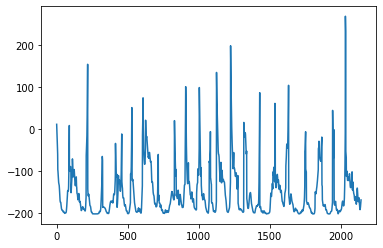

In [95]:
plt.plot(score_all)

Accuracy 	0.9487
AUC score 	0.9297
FAR score 	0.6721
Precision 	0.3279
Recall   	0.2247
Macro F1 	0.6200
weighted F1 	0.9441
Avg Precision 	0.2901
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2054
           1       0.33      0.22      0.27        89

    accuracy                           0.95      2143
   macro avg       0.65      0.60      0.62      2143
weighted avg       0.94      0.95      0.94      2143



[0.948670088660756,
 0.929690491559358,
 0.6721311475409836,
 0.32786885245901637,
 0.2247191011235955,
 0.6200354609929078,
 0.944053044217856,
 0.29012565360727727]

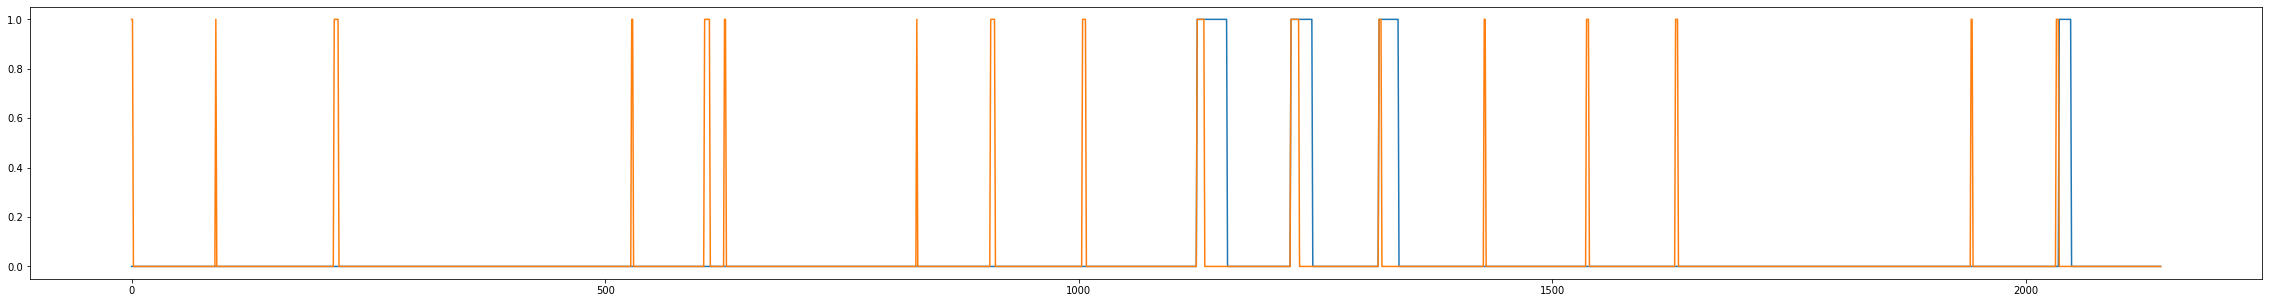

In [96]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9748
AUC score 	0.9297
FAR score 	0.3504
Precision 	0.6496
Recall   	0.8539
Macro F1 	0.8623
weighted F1 	0.9764
Avg Precision 	0.2901
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2054
           1       0.65      0.85      0.74        89

    accuracy                           0.97      2143
   macro avg       0.82      0.92      0.86      2143
weighted avg       0.98      0.97      0.98      2143



[0.9748016798880075,
 0.929690491559358,
 0.3504273504273504,
 0.6495726495726496,
 0.8539325842696629,
 0.862314391776128,
 0.976427722256171,
 0.29012565360727727]

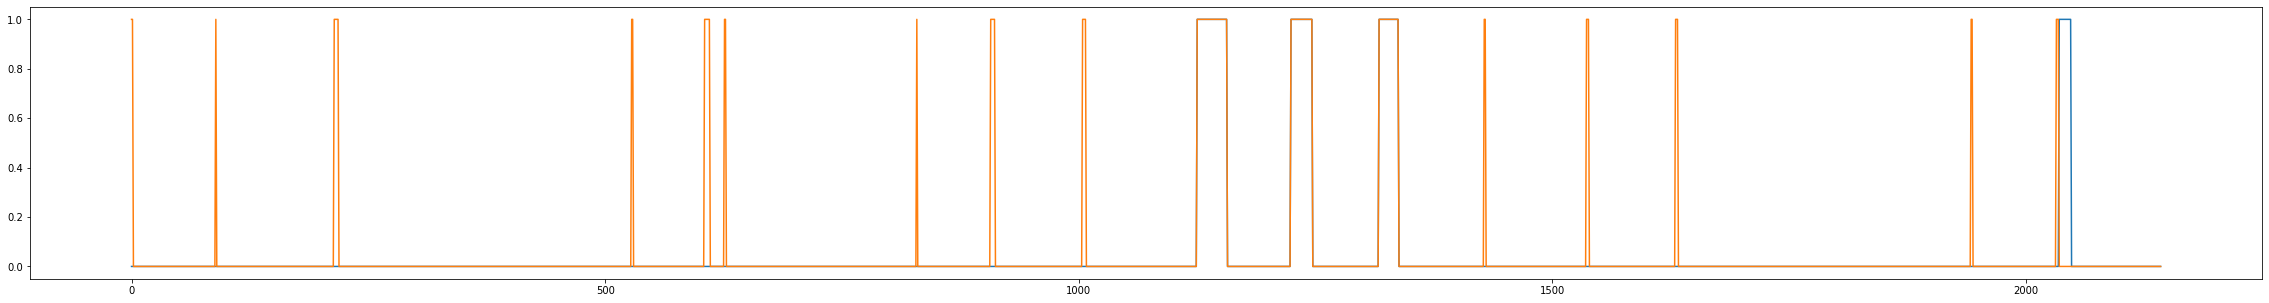

In [97]:
pred = [1 if s > 0 else 0 for s in score_all]
evaluate(label_all, pred, score_all, adjust=True, plot=True, print_=True)

In [98]:
cm = confusion_matrix(label_all, (score_all > 0).astype(int))
cm

array([[2013,   41],
       [  69,   20]])

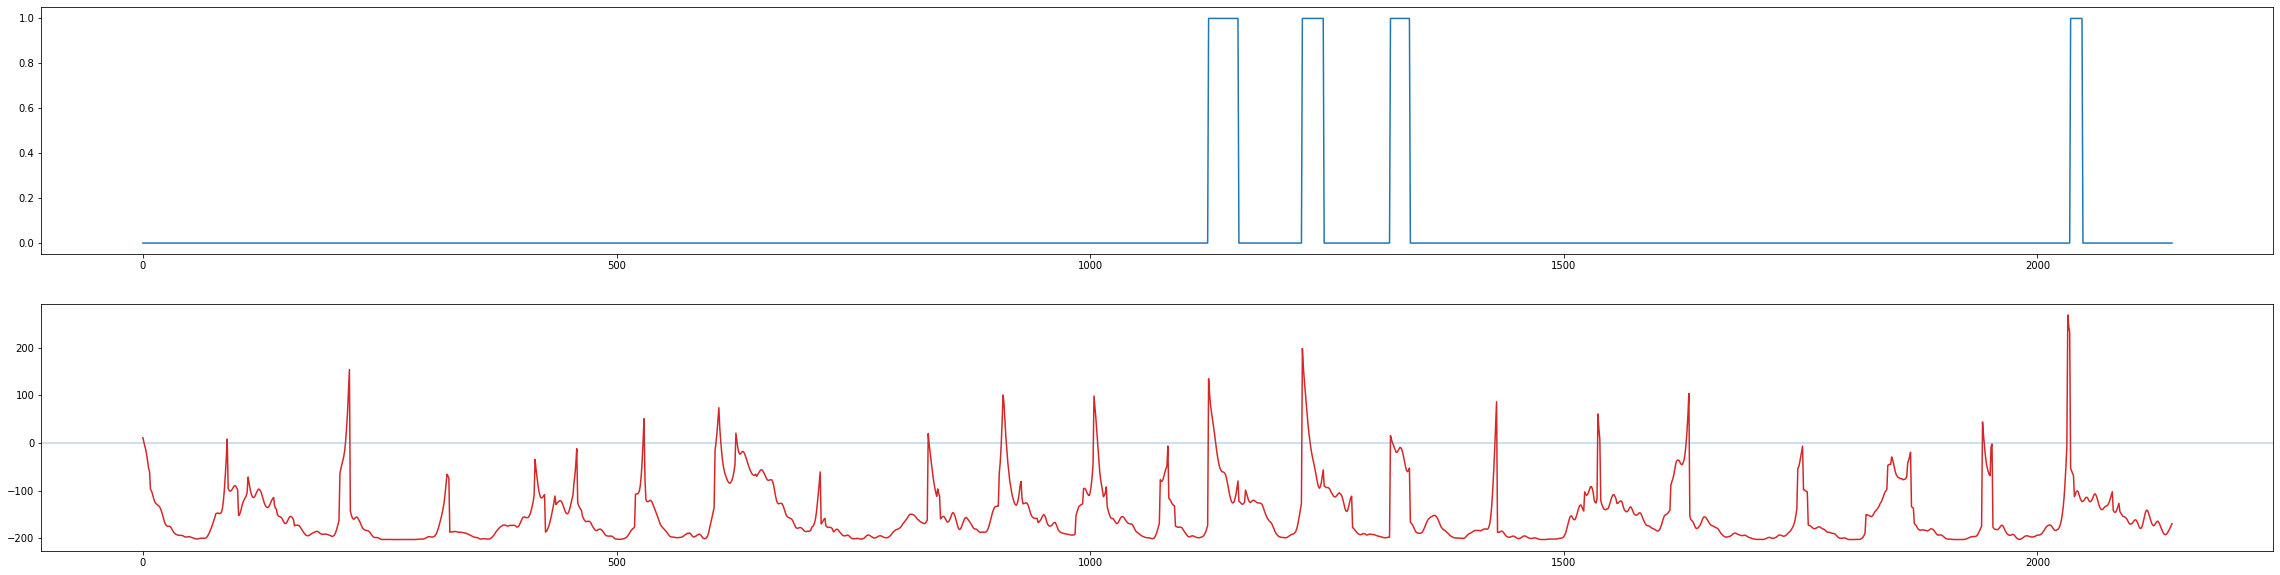

In [99]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


## Case prediction plot

In [100]:
tp = np.where((label_all == 1) & ((score_all > 0).astype(int) == 1))[0]
fp = np.where((label_all == 0) & ((score_all > 0).astype(int) == 1))[0]
tn = np.where((label_all == 0) & ((score_all > 0).astype(int) == 0))[0]
fn = np.where((label_all == 1) & ((score_all > 0).astype(int) == 0))[0]

tmp = np.random.choice(tp, 10)
tmp

array([1227, 1319, 1228, 1130, 1128, 1130, 1125, 1224, 1126, 1127])

In [101]:
print(target_sid)
eventID = accident_all[accident_all.accident_sid == target_sid].eventId[0]

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'

with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

hop1_up = list(np.unique([p[1] for p in path_inflow]))
hop1_down = list(np.unique([p[1] for p in path_outflow]))

test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
test_df.columns = test_df.columns.astype(int)

1210005301


In [102]:
def speed_agg(test_df):

    df_agg_inflow, df_agg_outflow = [], []
    for hop in [0, 1, 2, 3]:
        inflow = np.unique([p[hop] for p in path_inflow])
        outflow = np.unique([p[hop] for p in path_outflow])
        inflow = [p for p in inflow if p in list(test_df.columns)]
        outflow = [p for p in outflow if p in list(test_df.columns)]
        df_agg_inflow.append(test_df[inflow].mean(axis=1))
        df_agg_outflow.append(test_df[outflow].mean(axis=1))
    df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
    df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

    return df_agg_inflow, df_agg_outflow

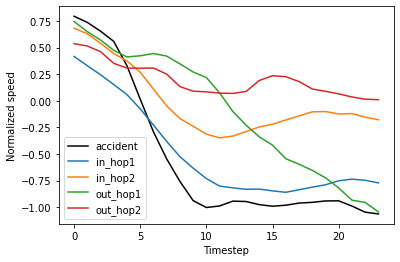

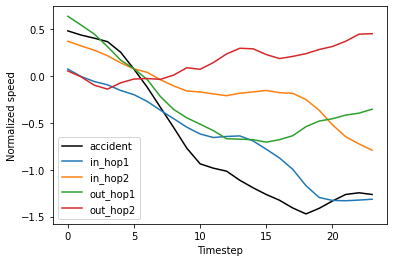

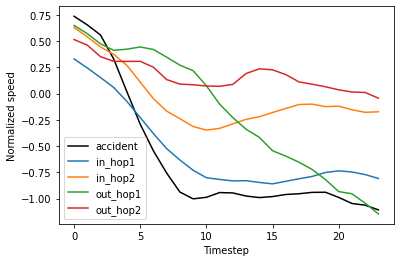

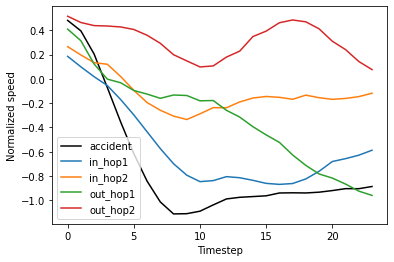

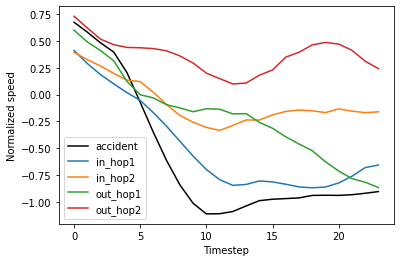

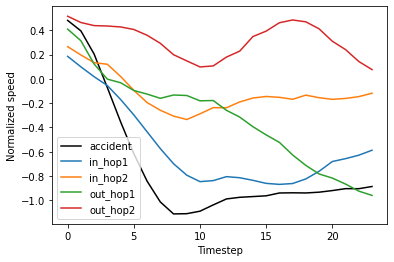

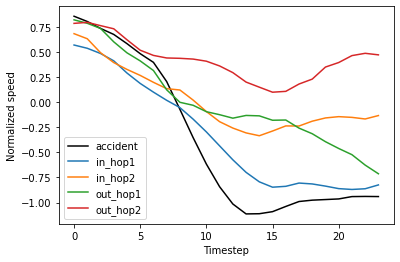

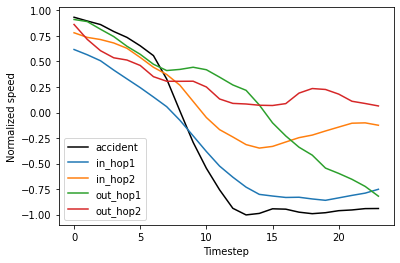

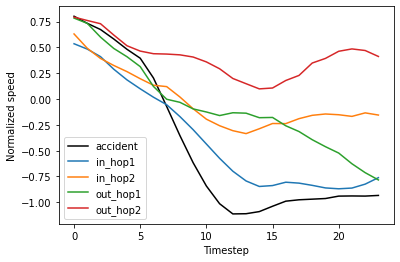

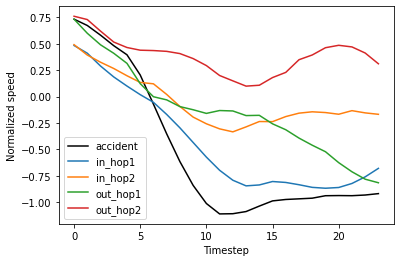

In [103]:
bs = args.batch_size
n_node = 25
for detected in tmp[:10]:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    plt.figure()
    plt.plot(df_agg_inflow[0], label='accident', color='k')
    plt.plot(df_agg_inflow[1], label='in_hop1')
    plt.plot(df_agg_inflow[2], label='in_hop2')
    plt.plot(df_agg_outflow[2], label='out_hop1')
    plt.plot(df_agg_outflow[1], label='out_hop2')
    plt.legend()
    plt.ylabel('Normalized speed')
    plt.xlabel('Timestep')
    plt.show()

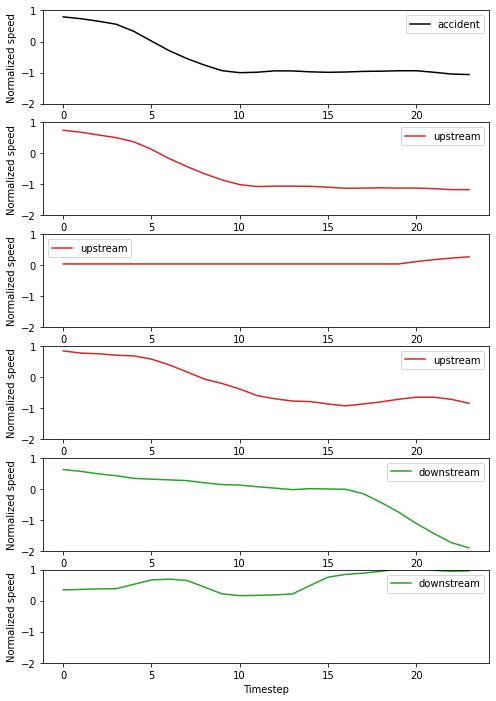

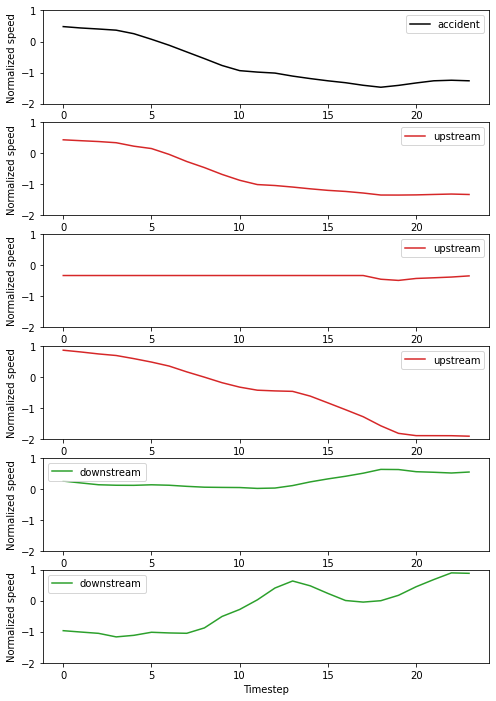

In [105]:
bs = args.batch_size
n_node = 25
for detected in tmp[:2]:
    i = detected // args.batch_size
    j = detected % args.batch_size

    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j], index=test_df.columns.astype(int)).T
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)


    fig, ax = plt.subplots(6, 1, figsize=(8, 12))
    ax[0].plot(tmp_df[target_sid], label='accident', color='k')
    ax[1].plot(tmp_df[hop1_up[0]], label='upstream', color='tab:red')
    ax[2].plot(tmp_df[hop1_up[1]], label='upstream', color='tab:red')
    # ax[3].plot(tmp_df[hop1_up[2]])
    ax[3].plot(tmp_df[hop1_up[3]], label='upstream', color='tab:red')
    ax[4].plot(tmp_df[hop1_down[0]], label='downstream', color='tab:green')
    ax[5].plot(tmp_df[hop1_down[1]], label='downstream', color='tab:green')
    
    
    for k in range(6):
        ax[k].set_ylim(-2, 1)
        ax[k].legend()
        ax[k].set_ylabel('Normalized speed')
        ax[k].set_xlabel('Timestep')
    plt.show()

In [106]:
detected = np.where(score_all > 0)[0]

In [107]:
detected, len(detected), len(test_loader)*args.batch_size*0.03

(array([   0,    1,   89,  214,  215,  216,  217,  218,  528,  529,  605,
         606,  607,  608,  609,  610,  626,  627,  829,  907,  908,  909,
         910,  911, 1004, 1005, 1006, 1007, 1125, 1126, 1127, 1128, 1129,
        1130, 1131, 1132, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231,
        1232, 1317, 1318, 1319, 1428, 1429, 1536, 1537, 1538, 1630, 1631,
        1632, 1942, 1943, 2032, 2033, 2034]),
 61,
 65.28)

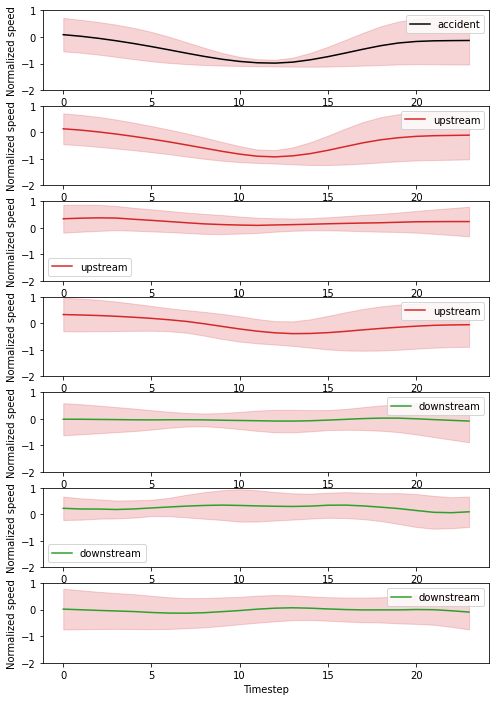

In [127]:
bs = args.batch_size
n_node = 25
pattern_all = []
# for detect_ix in detected:
for detect_ix in fp:
    i = detect_ix // args.batch_size
    j = detect_ix % args.batch_size


    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j]).T
            pattern_all.append(tmp_df)
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)
            break


pattern_mean = pd.DataFrame(np.nanmean(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_std = pd.DataFrame(np.nanstd(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_ub = pattern_mean + pattern_std
pattern_lb = pattern_mean - pattern_std

fig, ax = plt.subplots(7, 1, figsize=(8, 12))
ax[0].plot(pattern_mean[target_sid], label='accident', color='k')
ax[0].fill_between(np.arange(24), pattern_lb[target_sid], pattern_ub[target_sid], color='tab:red', alpha=0.2)

ax[1].plot(pattern_mean[hop1_up[0]], label='upstream', color='tab:red')
ax[1].fill_between(np.arange(24), pattern_lb[hop1_up[0]], pattern_ub[hop1_up[0]], color='tab:red', alpha=0.2)

ax[2].plot(pattern_mean[hop1_up[1]], label='upstream', color='tab:red')
ax[2].fill_between(np.arange(24), pattern_lb[hop1_up[1]], pattern_ub[hop1_up[1]], color='tab:red', alpha=0.2)

ax[3].plot(pattern_mean[hop1_up[3]], label='upstream', color='tab:red')
ax[3].fill_between(np.arange(24), pattern_lb[hop1_up[3]], pattern_ub[hop1_up[3]], color='tab:red', alpha=0.2)

ax[4].plot(pattern_mean[hop1_down[0]], label='downstream', color='tab:green')
ax[4].fill_between(np.arange(24), pattern_lb[hop1_down[0]], pattern_ub[hop1_down[0]], color='tab:red', alpha=0.2)

ax[5].plot(pattern_mean[hop1_down[1]], label='downstream', color='tab:green')
ax[5].fill_between(np.arange(24), pattern_lb[hop1_down[1]], pattern_ub[hop1_down[1]], color='tab:red', alpha=0.2)

ax[6].plot(pattern_mean[hop1_down[2]], label='downstream', color='tab:green')
ax[6].fill_between(np.arange(24), pattern_lb[hop1_down[2]], pattern_ub[hop1_down[2]], color='tab:red', alpha=0.2)


for k in range(7):
    ax[k].set_ylim(-2, 1)
    ax[k].legend()
    ax[k].set_ylabel('Normalized speed')
    ax[k].set_xlabel('Timestep')
plt.show()

#### 실제 데이터의 패턴 확인

In [111]:
RC = np.where((label_all == 0))[0]
NRC = np.where((label_all == 1))[0]

In [112]:
np.random.choice(RC, 100)

array([1478,  392,   14, 1541,  793,  494,  725, 1249, 1872,  880,  810,
        637, 1995,  709, 1002, 1641,   58, 1051,  290, 1283, 1283, 1379,
       1304,  700, 2071,  909, 1014, 1368, 1374, 1359,  148, 1277, 1764,
        349, 1685,  877,  659, 2094,   35, 1276, 1115, 2133, 1479,  444,
        125,  403,   45,  556, 1408, 1762, 1788, 1910, 1550,  824, 1916,
        350, 1347, 1033,  205,  297,  543, 2134,  840, 1561,  136,  489,
       1852,  569, 2099, 1032, 1704, 1890,  907, 1659,  717, 1295,  765,
       1916,  514,  591,  443,  712,  224,  889, 1794, 1693,  505,    2,
       1074,  747, 1500,  610, 1296,  347,  584, 2079, 1055,  513, 1020,
       1970])

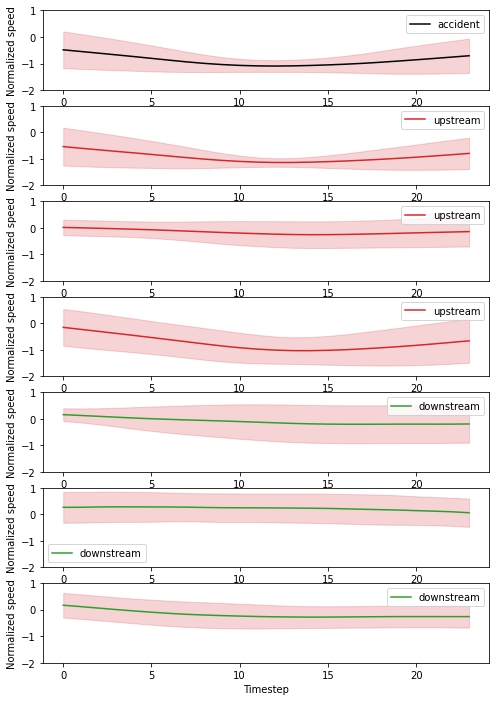

In [123]:
bs = args.batch_size
n_node = 25
pattern_all = []
for detect_ix in NRC:
# for detect_ix in np.random.choice(RC, 100):
    i = detect_ix // args.batch_size
    j = detect_ix % args.batch_size


    for ix, data in enumerate(test_loader):
        if ix == i:
            tmp_df = pd.DataFrame(data.x[data.batch == j]).T
            pattern_all.append(tmp_df)
            df_agg_inflow, df_agg_outflow = speed_agg(tmp_df)
            break


pattern_mean = pd.DataFrame(np.nanmean(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_std = pd.DataFrame(np.nanstd(pattern_all, axis=0), columns=test_df.columns.astype(int))
pattern_ub = pattern_mean + pattern_std
pattern_lb = pattern_mean - pattern_std

fig, ax = plt.subplots(7, 1, figsize=(8, 12))
ax[0].plot(pattern_mean[target_sid], label='accident', color='k')
ax[0].fill_between(np.arange(24), pattern_lb[target_sid], pattern_ub[target_sid], color='tab:red', alpha=0.2)

ax[1].plot(pattern_mean[hop1_up[0]], label='upstream', color='tab:red')
ax[1].fill_between(np.arange(24), pattern_lb[hop1_up[0]], pattern_ub[hop1_up[0]], color='tab:red', alpha=0.2)

ax[2].plot(pattern_mean[hop1_up[1]], label='upstream', color='tab:red')
ax[2].fill_between(np.arange(24), pattern_lb[hop1_up[1]], pattern_ub[hop1_up[1]], color='tab:red', alpha=0.2)

ax[3].plot(pattern_mean[hop1_up[3]], label='upstream', color='tab:red')
ax[3].fill_between(np.arange(24), pattern_lb[hop1_up[3]], pattern_ub[hop1_up[3]], color='tab:red', alpha=0.2)

ax[4].plot(pattern_mean[hop1_down[0]], label='downstream', color='tab:green')
ax[4].fill_between(np.arange(24), pattern_lb[hop1_down[0]], pattern_ub[hop1_down[0]], color='tab:red', alpha=0.2)

ax[5].plot(pattern_mean[hop1_down[1]], label='downstream', color='tab:green')
ax[5].fill_between(np.arange(24), pattern_lb[hop1_down[1]], pattern_ub[hop1_down[1]], color='tab:red', alpha=0.2)

ax[6].plot(pattern_mean[hop1_down[2]], label='downstream', color='tab:green')
ax[6].fill_between(np.arange(24), pattern_lb[hop1_down[2]], pattern_ub[hop1_down[2]], color='tab:red', alpha=0.2)



for k in range(7):
    ax[k].set_ylim(-2, 1)
    ax[k].legend()
    ax[k].set_ylabel('Normalized speed')
    ax[k].set_xlabel('Timestep')
plt.show()

### Prediction Case for true incident

In [117]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

Detected
MTTD = [0]


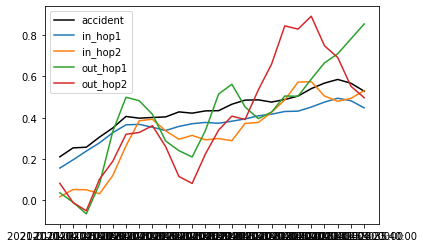

Detected
MTTD = [0]


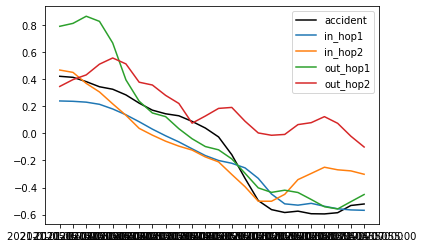

Detected
MTTD = [0]


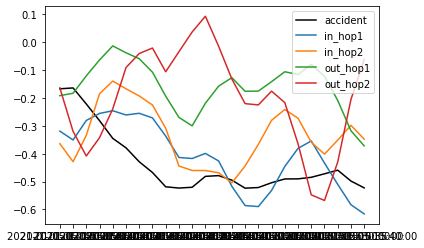

Not detected


In [118]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        if pred[st] == 1:
            print('MTTD = [0]')
            i = st
        else:
            print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])
            i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop2')
        plt.legend()
        plt.show()
    

## embedding distribution plot

### Test set

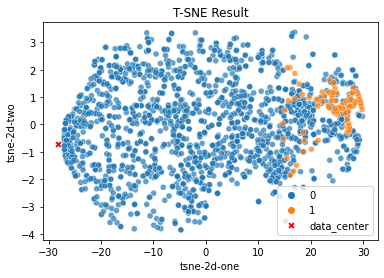

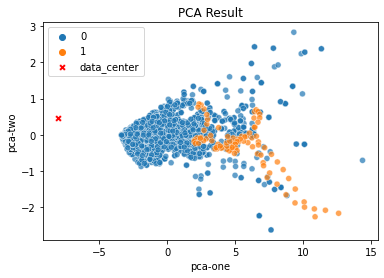

In [44]:
## test set all T-SNE
import seaborn as sns 


normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=200)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]['pca-one'], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)


plt.title('PCA Result')
plt.show()

Text(0, 0.5, 'Distance')

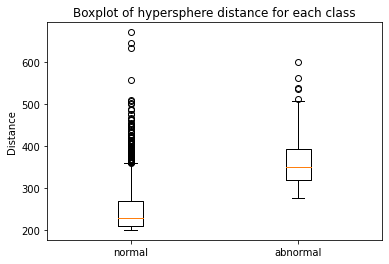

In [53]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

/tmp/ipykernel_2726875/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


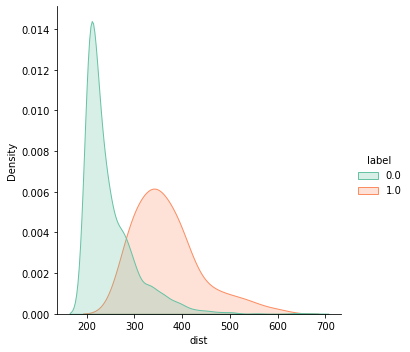

In [54]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### T-SNE comparison

57 19 17
Parameter number of GCN_gc Net is: 7840
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_GCN_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 39.78it/s]


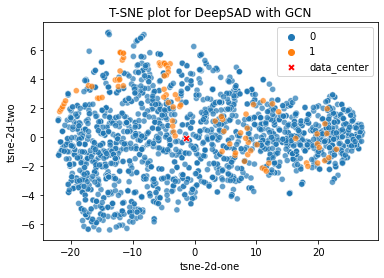

Parameter number of GAT_gc Net is: 293984
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_GAT_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 38.80it/s]


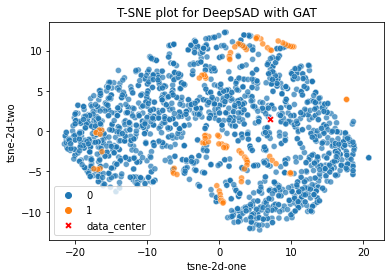

Parameter number of GraphSAGE_gc Net is: 15520
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_GraphSAGE_sum_0.03_True+bestcheckpoint.pt


17it [00:00, 54.87it/s]


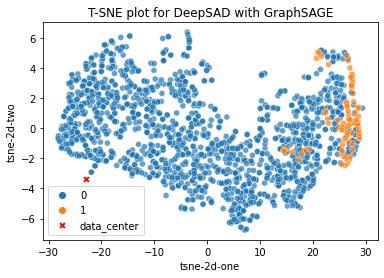

Parameter number of STGCN Net is: 4532
./checkpoints_SAD_CV/1210005301_CV2/1210005301_CV2_6_STGCN_sum_0.03_True+bestcheckpoint.pt


17it [00:02,  8.42it/s]


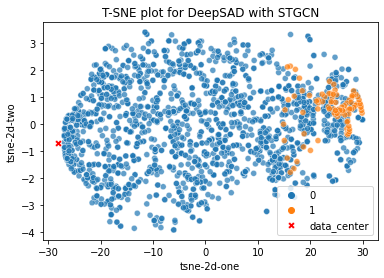

In [45]:
args.dataset = '1210005301_CV2'
args.kfold = 6
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))


for module, name in zip(['GCN_gc', 'GAT_gc', 'GraphSAGE_gc', 'STGCN'], ['GCN','GAT', 'GraphSAGE', 'STGCN']):
# for module, name in zip(['GraphSAGE_gc'], ['GraphSAGE']):
    
    args.module = module
    name = name
    args.normalize = 'standard'
    args.nu = 0.03
    args.pooling = 'sum'
    args.reverse = False
    args.self_loop = 'True'
    args.bias = True

    args.exp_name = f'{args.dataset}_{args.kfold}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'

    checkpoints_path=f'./checkpoints_SAD_CV/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
    
    input_dim = 24
    model = init_model(args, input_dim)
    print(checkpoints_path)

    model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
    model.to(device=f'cuda:{args.gpu}')
    model.eval()
    data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
    radius = torch.load(checkpoints_path, map_location='cuda')['radius']


#     out_all, dist_all, score_all = [], [], []
#     label_all = []
#     for ix, data in tqdm(enumerate(val_loader)):
#         output = model(data.to(device=f'cuda:{args.gpu}'))
#         out_all.append(output.cpu().detach().numpy())
#         label_all.append(data.y.cpu().detach().numpy())
#         # dist, score = anomaly_score(data_center, output, radius)
#         dist = torch.sum((output - data_center) ** 2, dim=1)
#         dist_all.append(dist.cpu().detach().numpy())
#     dist_all = np.concatenate(dist_all)
#     print(dist_all[:5])
#     # new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
#     new_radius = np.quantile(np.sqrt(dist_all), 0.97)
#     new_radius


    out_all, dist_all, score_all = [], [], []
    label_all = []
    for ix, data in tqdm(enumerate(test_loader)):
        output = model(data.to(device=f'cuda:{args.gpu}'))
        out_all.append(output.cpu().detach().numpy())
        label_all.append(data.y.cpu().detach().numpy())
    label_all = np.concatenate(label_all)

    

    ## test set all T-SNE
    import seaborn as sns 


    normal = np.where(label_all == 0)[0]
    abnormal = np.where(label_all == 1)[0]

    rndperm = np.random.choice(normal, 2000)

    ## add data center
    center_arr = data_center.detach().cpu().numpy()
    out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

    ## tSNE
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, perplexity=200, random_state=0)
    tsne_all = tsne.fit_transform(out_center_all)

    tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
    tsne_df['y'] = np.append(label_all, [-1])

    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("tab10", 2),
        data=tsne_df.loc[np.append(rndperm, abnormal), :],
        legend="full",
        alpha=0.7
    )
    sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
        color='red',
        marker='X',
        s=50,
        label='data_center'
    )

    plt.title('T-SNE plot for DeepSAD with {}'.format(name))
    plt.show()


    

# All Incidents

In [31]:
out_1 = pd.read_csv('result/1210005301_mprofile2_sumpool.csv', index_col=0)
out_2 = pd.read_csv('result/1030001902_mprofile2_sumpool.csv', index_col=0)
out_3 = pd.read_csv('result/1220005401_mprofile2_sumpool.csv', index_col=0)
out_4 = pd.read_csv('result/1210003000_mprofile2_sumpool.csv', index_col=0)
# out_5 = pd.read_csv('result/1130052300_mprofile_sumpool.csv', index_col=0)

In [72]:
out_1

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.012346,0.666667,0.333333,0.012346,0.920039,0.616965,0.491061,0.884500,0.188619
2,GAT,standard,0.01,False,0.037037,0.142857,0.857143,0.037037,0.923452,0.618019,0.515544,0.889857,0.269215
4,GraphSAGE,standard,0.01,False,0.055556,0.100000,0.900000,0.055556,0.924915,0.725814,0.532733,0.893189,0.257302
6,STGCN,standard,0.01,False,0.024691,0.000000,1.000000,0.024691,0.922964,0.724049,0.504025,0.887849,0.267980
8,GCN,standard,0.05,False,0.098765,0.589744,0.410256,0.098765,0.917601,0.495588,0.557941,0.893689,0.194595
10,GAT,standard,0.05,False,0.154321,0.778761,0.221239,0.154321,0.890297,0.663664,0.561513,0.881226,0.185384
12,GraphSAGE,standard,0.05,False,0.141975,0.540000,0.460000,0.141975,0.919064,0.681058,0.587154,0.898850,0.251239
14,STGCN,standard,0.05,False,0.148148,0.333333,0.666667,0.148148,0.926865,0.709821,0.602001,0.904775,0.315841
16,GCN,standard,0.10,False,0.129630,0.866242,0.133758,0.129630,0.864944,0.661487,0.529220,0.863975,0.121948
18,GAT,standard,0.10,False,0.185185,0.610390,0.389610,0.185185,0.912725,0.608376,0.602354,0.898166,0.255224


In [32]:
out_1 = out_1[out_1.adjust == False]
out_2 = out_2[out_2.adjust == False]
out_3 = out_3[out_3.adjust == False]
out_4 = out_4[out_4.adjust == False]
# out_5 = out_5[out_5.adjust == False]

In [33]:
tmp = np.nanmean([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:]], axis=0)  # , out_5.iloc[:,4:]
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.006333,0.866667,0.133333,0.006333,0.908096,0.526892,0.481715,0.867226,0.122769
2,GAT,standard,0.01,False,0.025433,0.524520,0.475480,0.025433,0.889198,0.531713,0.490848,0.860543,0.147449
4,GraphSAGE,standard,0.01,False,0.092193,0.631613,0.368387,0.092193,0.868655,0.574907,0.523633,0.858480,0.153830
6,STGCN,standard,0.01,False,0.017262,0.664223,0.335777,0.017262,0.904443,0.586891,0.490432,0.867402,0.162956
8,GCN,standard,0.05,False,0.033883,0.879579,0.120421,0.033883,0.873505,0.464816,0.491553,0.853448,0.107484
10,GAT,standard,0.05,False,0.064403,0.868213,0.131787,0.064403,0.880537,0.539349,0.509248,0.859705,0.121613
12,GraphSAGE,standard,0.05,False,0.099119,0.800298,0.199702,0.099119,0.854289,0.563631,0.516338,0.847350,0.148151
14,STGCN,standard,0.05,False,0.107308,0.751542,0.248458,0.107308,0.864502,0.606459,0.525826,0.855021,0.170766
16,GCN,standard,0.10,False,0.115225,0.916782,0.083218,0.115225,0.788369,0.458644,0.483889,0.806456,0.087048
18,GAT,standard,0.10,False,0.141720,0.750146,0.249854,0.141720,0.857130,0.587761,0.531364,0.850795,0.166198


In [34]:
out_all.to_csv('result/mprofile2_out_all.csv')

In [31]:
tmp = np.nanstd([out_1.iloc[:, 4:], out_2.iloc[:, 4:], out_3.iloc[:,4:], out_4.iloc[:,4:], out_5.iloc[:,4:]], axis=0)
tmp = pd.DataFrame(tmp, columns=out_1.columns[4:], index=out_1.index)
out_all = pd.concat([out_1.iloc[:, :4], tmp], axis=1)
out_all

,model,normalize,nu,adjust,DR,far,precision,recall,acc,AUC,F1_macro,F1_weight,AP
0,GCN,standard,0.01,False,0.020770,0.435890,0.435890,0.020770,0.029469,0.171800,0.023073,0.030105,0.102022
2,GAT,standard,0.01,False,0.038315,0.370919,0.370919,0.038315,0.015818,0.104169,0.033070,0.021192,0.080703
4,GraphSAGE,standard,0.01,False,0.035722,0.386025,0.386025,0.035722,0.028615,0.154496,0.036325,0.028236,0.119037
6,STGCN,standard,0.01,False,0.026007,0.335648,0.335648,0.026007,0.021920,0.136423,0.025812,0.028781,0.137002
8,GCN,standard,0.05,False,0.063055,0.247957,0.247957,0.063055,0.060933,0.154225,0.061311,0.046852,0.098468
10,GAT,standard,0.05,False,0.088899,0.131186,0.131186,0.088899,0.064405,0.177712,0.051730,0.047917,0.083508
12,GraphSAGE,standard,0.05,False,0.087089,0.080940,0.080940,0.087089,0.088340,0.141454,0.045754,0.060321,0.064348
14,STGCN,standard,0.05,False,0.064498,0.337616,0.337616,0.064498,0.029931,0.160499,0.030952,0.028844,0.177834
16,GCN,standard,0.10,False,0.100271,0.098288,0.098288,0.100271,0.040522,0.120213,0.054917,0.031482,0.112822
18,GAT,standard,0.10,False,0.072452,0.163243,0.163243,0.072452,0.062634,0.087068,0.063751,0.047214,0.106457


In [32]:
out_all.to_csv('result/mprofile_out_std.csv')